## Use k-Means clustering on economic, racial, age, district size, mean distance in voting behavior

- get dataframe from CSVs
- construct desired sets of predictors
- prepare labels
- run cluster algo
- encode clusters into existing data frame
- visual clusters
- identify cluster-defining properties

In [1]:
import pandas as pd
import numpy as np
from sklearn import cluster as skclust
from sklearn import preprocessing as skproc
from sklearn import metrics as skmetric
import matplotlib.pyplot as plt
import time
import re
%matplotlib inline

In [2]:
df = pd.read_csv("data/county_facts.csv")

In [3]:
rename_map={"PST045214": "Pop2014",
            "PST040210": "Pop2010EST",
            "PST120214": "Pop%Change",
            "POP010210": "Pop2010",
            "AGE135214": "Under5%",
            "AGE295214": "Under18%",
            "AGE775214": "Over65%",
            "SEX255214": "Female%",
            "RHI125214": "White%",
            "RHI225214": "Black%",
            "RHI325214": "NativeA%",
            "RHI425214": "Asian%",
            "RHI525214": "PIsland%",
            "RHI625214": "TwoRace%",
            "RHI725214": "Latino",
            "RHI825214": "WhiteNLat%",
            "POP715213": "SameHouse1yr%",
            "POP645213": "ForeignBorn%",
            "POP815213": "NonEnglish%",
            "EDU635213": "HighSchoolGrad%",
            "EDU685213": "Bachelor%",
            "VET605213": "Veteran",
            "LFE305213": "TravelTime",
            "HSG010214": "HousingUnits",
            "HSG445213": "OwnershipRate",
            "HSG096213": "UnitsinMultiUnit%",
            "HSG495213": "MedianValueHousing",
            "HSD410213": "Households",
            "INC910213": "PerCapitaIncome",
            "INC110213": "MedianIncome",
            "PVY020213": "%BelowPoverty",
            "BZA010213": "PrivateNotFarmsEstablish",
            "BZA110213": "PrivateNotFarmEmploy",
            "BZA115213": "NotFarm%Change",
            "NES010213": "NonEmployerEstablish",
            "SBO315207": "Black-owned%",
            "SBO115207": "Native-owned%",
            "SBO215207": "Asian-owned%",
            "SBO515207": "PIslnder-owned%",
            "SBO415207": "Hispanic-owned%",
            "SBO015207": "Woman-owned",
            "MAN450207": "Manfact shipments 1k",
            "WTN220207": "Merchant sales 1k",
            "RTN130207": "Retail sales 1k",
            "RTN131207": "Retail sales/capita",
            "AFN120207": "Accomd/FoodServ sales 1k",
            "BPS030214": "BuildingPermits",
            "LND110210": "LandArea",
            "POP060210": "Pop/SqMile"}
df=df.rename(index=str,columns=rename_map)

In [4]:
## aggregate state/national data hold NaN values in state_abbrev
counties = df.dropna()
not_counties = df[~df.index.isin(counties.index)]

In [5]:
cf_dict = pd.read_csv("data/county_facts_dictionary.csv")
cf_dict = cf_dict.rename(index=str,columns=rename_map)

In [6]:
cf_dict.head()

,column_name,description
0,PST045214,"Population, 2014 estimate"
1,PST040210,"Population, 2010 (April 1) estimates base"
2,PST120214,"Population, percent change - April 1, 2010 to ..."
3,POP010210,"Population, 2010"
4,AGE135214,"Persons under 5 years, percent, 2014"


In [7]:
vote_data = pd.read_csv("data/US_County_Level_Presidential_Results_12-16.csv").rename(columns={"FIPS":"fips"})
rm = ['combined_fips', 'state_abbr', 'Unnamed: 0', 'county_name', 'county_fips', 'state_fips']
counties = pd.merge(counties, vote_data, on="fips").drop(rm, axis=1).dropna()
### LOSE ALASKAN COUNTY DATA


Make subsets for various clustering parameters.

In [8]:
### County size / population density
geographic_predictors =  ["Pop/SqMile"]

#### Population/Age/Education
county_demog_predictors = ["Pop%Change", "Under5%","Under18%", "Over65%",
                          "HighSchoolGrad%","Bachelor%", "Veteran"]
### HOUSING 
housing_predictors = ["SameHouse1yr%", "TravelTime", "HousingUnits", "OwnershipRate", "UnitsinMultiUnit%",
                        "MedianValueHousing", "Households"]
### ECONOMIC
econ_predictors = ["PerCapitaIncome", "MedianIncome", "%BelowPoverty", "PrivateNotFarmsEstablish",
                   "PrivateNotFarmEmploy", "NotFarm%Change", "NonEmployerEstablish","Manfact shipments 1k",
                   "Merchant sales 1k", "Retail sales/capita", "Retail sales/capita", "BuildingPermits"]
##### ETHNIC 
racial_predictors = ["Female%", "White%", "Black%","NativeA%","Asian%","PIsland%",
                     "TwoRace%","Latino","WhiteNLat%","ForeignBorn%",
                     "NonEnglish%"]
#### ETHNIC ECONO
racial_econo_predictors = ["Black-owned%","Native-owned%","Asian-owned%","PIslnder-owned%","Woman-owned"]

## VOTING
vote_predictors = ['total_votes_2016', 'per_dem_2016', 'per_gop_2016', 'per_point_diff_2016',
                   'total_votes_2012', 'per_dem_2012', 'per_gop_2012', 'per_point_diff_2012', "turnout_2016", "turnout_2012"]
#     ['votes_dem_2016', 'votes_gop_2016', 'total_votes_2016', 'per_dem_2016',
#        'per_gop_2016', 'diff_2016', 'per_point_diff_2016', 'total_votes_2012',
#        'votes_dem_2012', 'votes_gop_2012', 'per_dem_2012', 'per_gop_2012',
#        'diff_2012', 'per_point_diff_2012']

create some features for voting date to determine turnout

In [9]:
counties["turnout_2016"] = counties.total_votes_2016 / counties.Pop2014
counties["turnout_2012"] = counties.total_votes_2012 / counties.Pop2010

### Lets look at summary of various cluster parameters
##### County Demographics

In [10]:
# counties[county_demog_predictors].describe()

#### Economic 

In [11]:
# counties[econ_predictors].describe()

#### Racial / Ethnic / Gender

In [12]:
# counties[racial_predictors].describe()

In [13]:
# counties[vote_predictors].describe()

### Silhouette Analysis for tuning k 

In [14]:
def encode_clusters(data, col_key, label_mat, kth_score, best_k_dict, descrip):
    best_k_dict[descrip] = np.argmax(kth_score[descrip]) + 2
    data[col_key] = label_mat[best_k_dict[descrip]-2] ## store labels for best k
    data = pd.get_dummies(data, columns=[col_key])        
    data[col_key] = label_mat[best_k_dict[descrip] - 2] ##replace what get_dummies removed
    return data, best_k_dict

##### kMeans clustering.

In [15]:
def cluster_experiment_kmeans(data, predictor_lists:dict, max_clusters=20, scoring="sil"):
    start = time.time()
    best_k_dict = {}
    col_names = []
    kth_score = {}
    for descrip, X in predictor_lists.items():
        kth_score[descrip] = []
        label_mat = []
        col_key = descrip + "_kmeans"
        #normalize feature space
        X = skproc.minmax_scale(data[X], copy=False)
        
        ## run kmeans for each k [0,max_cluster]
        for k in range(2, max_clusters):
            kmeans = skclust.KMeans(n_clusters=k, n_jobs=-1, precompute_distances=True, n_init=15)
            kmeans.fit_predict(X)
            label_mat.append(kmeans.labels_)
            ##silhouette analysis
            if scoring == "sil":
                kth_score[descrip].append(skmetric.silhouette_score(X, label_mat[k - 2]))
            else:
                kth_score[descrip].append(skmetric.calinski_harabaz_score(X, label_mat[k - 2]))            

        ## add best cluster set to dataframe
        data, best_k_dict = encode_clusters(data, col_key, label_mat, kth_score, best_k_dict, descrip)
        #update with th new column names
        col_names.extend([col_key+"_"+str(int(k)) for k in range(best_k_dict[descrip])])
    
    print("Runtime: ", time.time() - start)
    return data, col_names, best_k_dict, kth_score
            
                

##### Agglomerative clustering.

In [16]:
def cluster_experiment_agglom(data, predictor_lists:dict, max_clusters=20, scoring="sil"):
    start = time.time()
    best_k_dict = {}
    col_names = []
    kth_score = {}
    for descrip, X in predictor_lists.items():
        kth_score[descrip] = []
        label_mat = []
        col_key = descrip + "_agglo"
        #normalize feature space
        X = skproc.minmax_scale(data[X], copy=False)

        for k in range(2, max_clusters):
            agglo = skclust.AgglomerativeClustering(n_clusters=k)
            agglo.fit_predict(X)
            ##silhouette analysis
            label_mat.append(agglo.labels_)
            if scoring == "sil":
                kth_score[descrip].append(skmetric.silhouette_score(X, label_mat[k - 2]))
            else:
                kth_score[descrip].append(skmetric.calinski_harabaz_score(X, label_mat[k - 2]))

        ## add best cluster set to dataframe
        data, best_k_dict = encode_clusters(data, col_key, label_mat, kth_score, best_k_dict, descrip)
        #update with th new column names
        col_names.extend([col_key+"_"+str(int(k)) for k in range(best_k_dict[descrip])])

    print("Runtime: ", time.time() - start)
    return data, col_names, best_k_dict, kth_score

##### Spectral Clustering

In [17]:
def cluster_experiment_spectral(data, predictor_lists:dict, max_clusters=5, scoring="sil"):
    start = time.time()
    best_k_dict = {}
    col_names = []
    kth_score = {}
    for descrip, X in predictor_lists.items():
        kth_score[descrip] = []
        label_mat = []
        col_key = descrip + "_spectral"
        #normalize feature space
        X = skproc.normalize(data[X])
        
        ## run kmeans for each k [0,max_cluster]
        for k in range(2, max_clusters):
            spec = skclust.SpectralClustering(n_clusters=k, n_jobs=-1)
            spec.fit_predict(X)
            ##silhouette analysis
            label_mat.append(spec.labels_)
            if scoring == "sil":
                kth_score[descrip].append(skmetric.silhouette_score(X, label_mat[k - 2]))
            else:
                kth_score[descrip].append(skmetric.calinski_harabaz_score(X, label_mat[k - 2]))
        ## add best cluster set to dataframe
        data, best_k_dict = encode_clusters(data, col_key, label_mat, kth_score, best_k_dict, descrip)
        print("Processed - ", descrip)
        #update with th new column names
        col_names.extend([col_key+"_"+str(int(k)) for k in range(best_k_dict[descrip])])

    print("Runtime: ", time.time() - start)
    return data, col_names, best_k_dict, kth_score

### Construct Feature Sets

In [18]:
X_dict={"demographic": county_demog_predictors, "economic": econ_predictors, "racial": racial_predictors,
        "geo": geographic_predictors, "housing": housing_predictors, "econXrace": racial_econo_predictors,
        "voting": vote_predictors}

### Run cluster analysis on each list of predictors.
#### kMeans, where 2 <= k < 20

In [19]:
counties, kmeans_dummies, kmeans_k_dict, kmeans_sil_scores = cluster_experiment_kmeans(counties, X_dict, scoring="sil")

Runtime:  80.93426442146301


##### Agglomerative, where 2 <= k < 20 using average linkage.

In [20]:
counties, agglo_dummies, agglo_k_dict, agglo_sil_score = cluster_experiment_agglom(counties, X_dict, scoring="sil")

Runtime:  74.9533200263977


#### Spectral cluster, using Nearest Neighbors Affinity for 2 <= k < 15

In [21]:
counties, spec_dummies, spec_k_dict, spec_sil_score = cluster_experiment_spectral(counties, X_dict, scoring="sil")

Processed -  racial
Processed -  voting
Processed -  econXrace
Processed -  geo
Processed -  housing
Processed -  demographic
Processed -  economic
Runtime:  31.608818531036377


### At this point, the clusters each clustering method is encoded into dataframe.

In [22]:
data = counties

In [23]:
kmeans_k_dict, agglo_k_dict, spec_k_dict

({'demographic': 3,
  'econXrace': 2,
  'economic': 2,
  'geo': 2,
  'housing': 3,
  'racial': 3,
  'voting': 2},
 {'demographic': 2,
  'econXrace': 2,
  'economic': 3,
  'geo': 2,
  'housing': 3,
  'racial': 3,
  'voting': 2},
 {'demographic': 2,
  'econXrace': 4,
  'economic': 3,
  'geo': 2,
  'housing': 2,
  'racial': 4,
  'voting': 3})

In [24]:
all_dummies = []
all_dummies.extend(kmeans_dummies)
all_dummies.extend(agglo_dummies)
all_dummies.extend(spec_dummies)
all_dummies = pd.Series(all_dummies).drop_duplicates()

cluster_counts = data[all_dummies].sum()
cluster_counts

racial_kmeans_0            359.0
racial_kmeans_1           2238.0
racial_kmeans_2            515.0
voting_kmeans_0           1027.0
voting_kmeans_1           2085.0
econXrace_kmeans_0         990.0
econXrace_kmeans_1        2122.0
geo_kmeans_0              3109.0
geo_kmeans_1                 3.0
housing_kmeans_0           419.0
housing_kmeans_1          1213.0
housing_kmeans_2          1480.0
demographic_kmeans_0      1427.0
demographic_kmeans_1       678.0
demographic_kmeans_2      1007.0
economic_kmeans_0         1434.0
economic_kmeans_1         1678.0
racial_agglo_0            2382.0
racial_agglo_1             461.0
racial_agglo_2             269.0
voting_agglo_0            2278.0
voting_agglo_1             834.0
econXrace_agglo_0         2156.0
econXrace_agglo_1          956.0
geo_agglo_0                 13.0
geo_agglo_1               3099.0
housing_agglo_0           1856.0
housing_agglo_1            811.0
housing_agglo_2            445.0
demographic_agglo_0       2268.0
demographi

In [25]:
def extract_dummy_subset(prefix:str):
    rtn = []
    for ele in cluster_counts.index:
        if prefix in ele:
            rtn.append(ele)
            
    return rtn

In [26]:
prefix=["racial","demographic","economic","housing","geo","econXrace", "voting"]
subset_masks = { p : extract_dummy_subset(p) for p in prefix}

In [27]:
data_by_subset = {key : data[subset_masks[key]] for key in kmeans_k_dict.keys()}
data_by_subset["racial"].columns

Index(['racial_kmeans_0', 'racial_kmeans_1', 'racial_kmeans_2',
       'racial_agglo_0', 'racial_agglo_1', 'racial_agglo_2',
       'racial_spectral_0', 'racial_spectral_1', 'racial_spectral_2',
       'racial_spectral_3'],
      dtype='object')

create subgroups for each clustering type

In [28]:
suffixes = ["kmeans", "agglo", "spectral"]
def get_clusters(key, suf):
    filt = { "kmeans": key+"_kmeans", "agglo" : key+"_agglo", "spectral": key+"_spectral"}
    df = data_by_subset[key].copy()
    cols=[]
    hdrs=df.columns
    for ele in hdrs:
        if filt[suf] in str(ele):
            cols.append(ele)
    
    return df[cols].sum().to_frame().T

def plot_cluster(key, suffix, t):
    f = plt.figure()
    get_clusters(key, suffix).plot(kind='bar', ax=f.gca(), title=t + " using " + suffix, alpha=.8)
    plt.legend(loc="right", bbox_to_anchor=(1.75, .5))
    plt.yticks()
    return plt

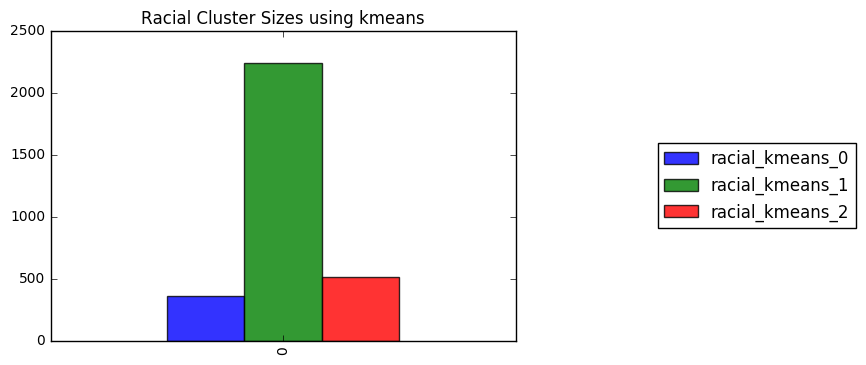

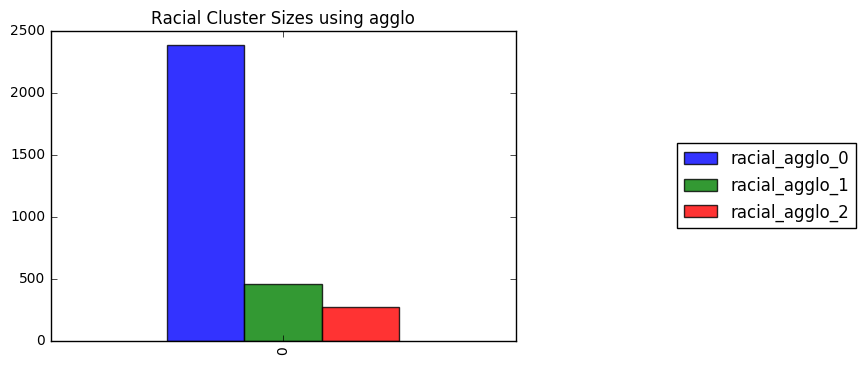

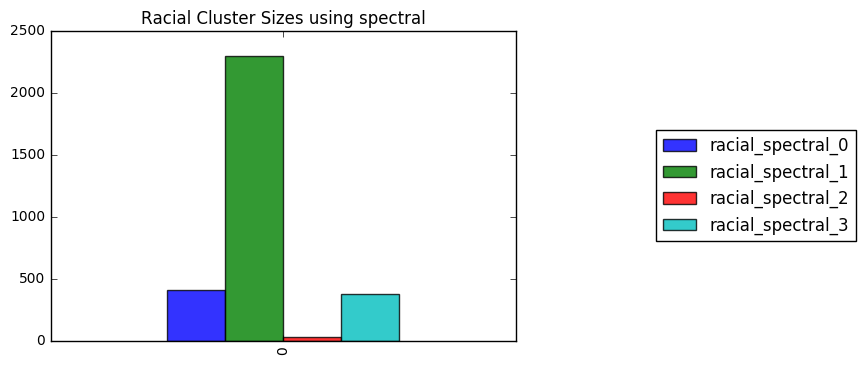

In [29]:
for i in range(3):
    plot_cluster("racial", suffixes[i], "Racial Cluster Sizes").show()

- a couple of clusters are very large while the rest are very small

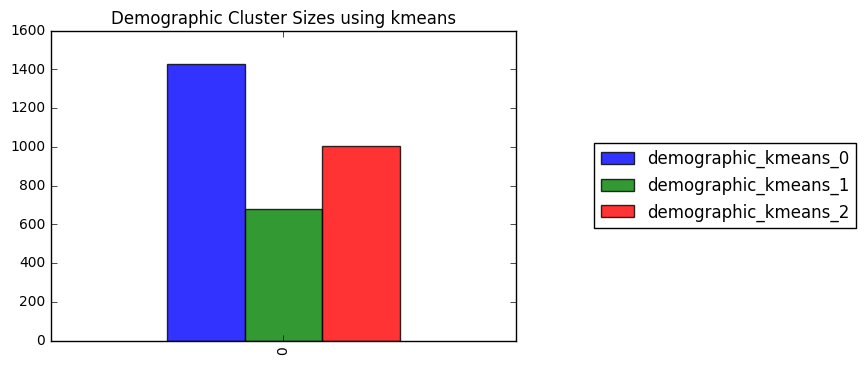

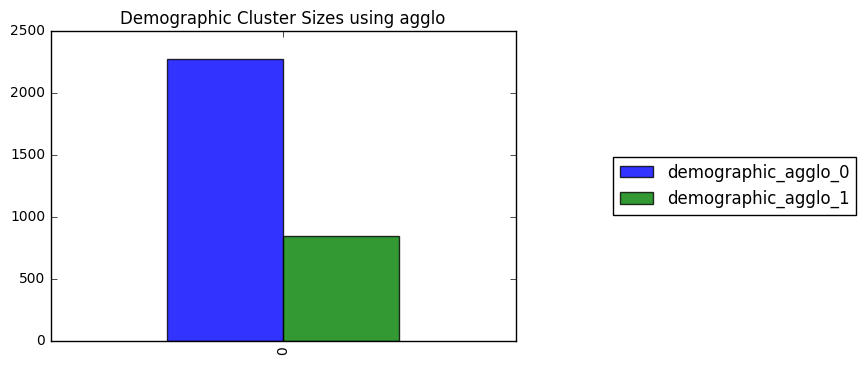

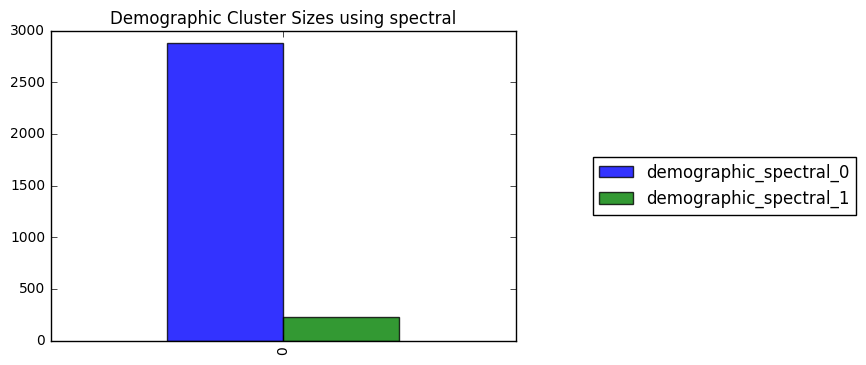

In [30]:
for i in range(3):
    plot_cluster("demographic", suffixes[i], "Demographic Cluster Sizes").show()

- cluster 0 is much smaller than the rest. 

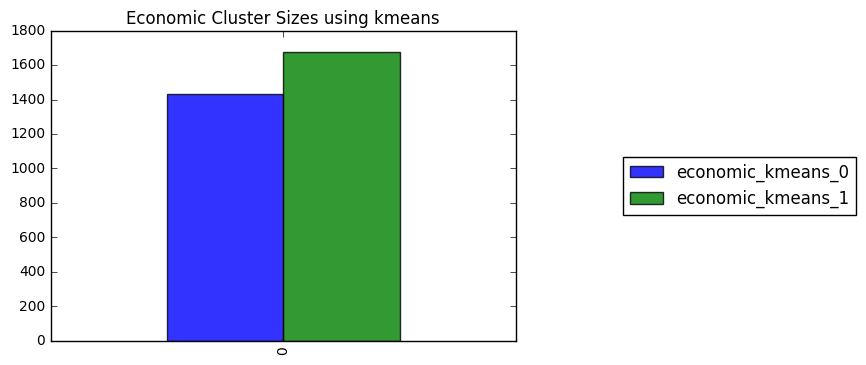

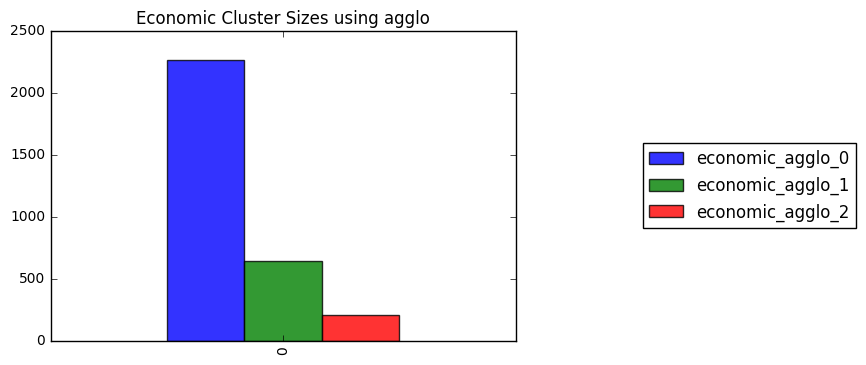

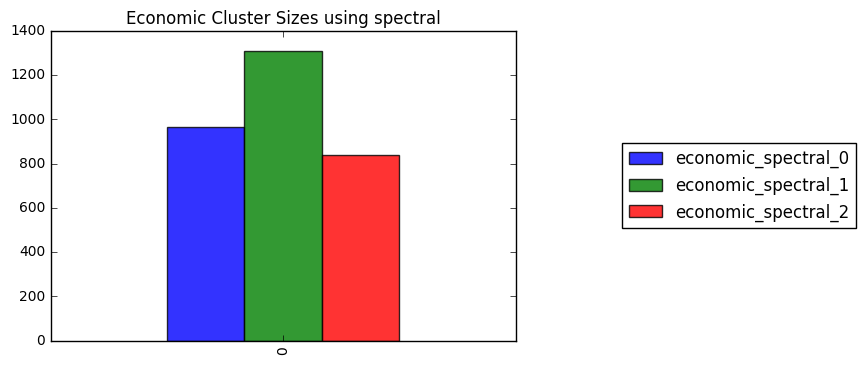

In [31]:
for i in range(3):
    plot_cluster("economic", suffixes[i], "Economic Cluster Sizes").show()

- cluster 4 seems significantly smaller than others.

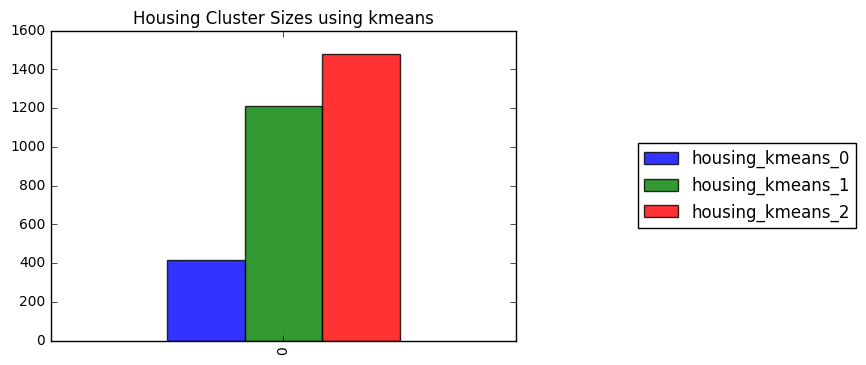

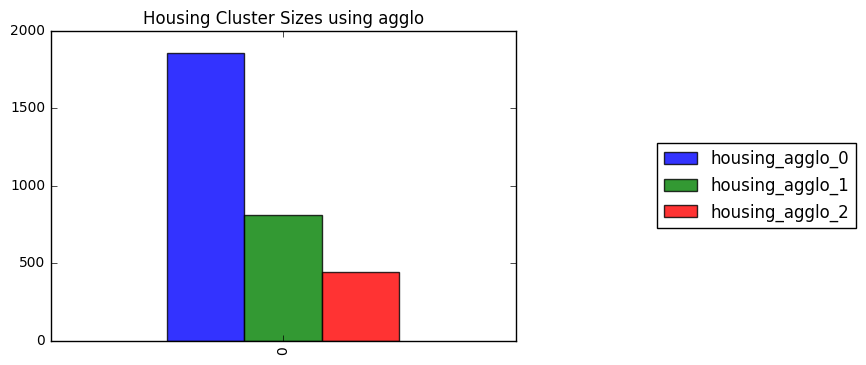

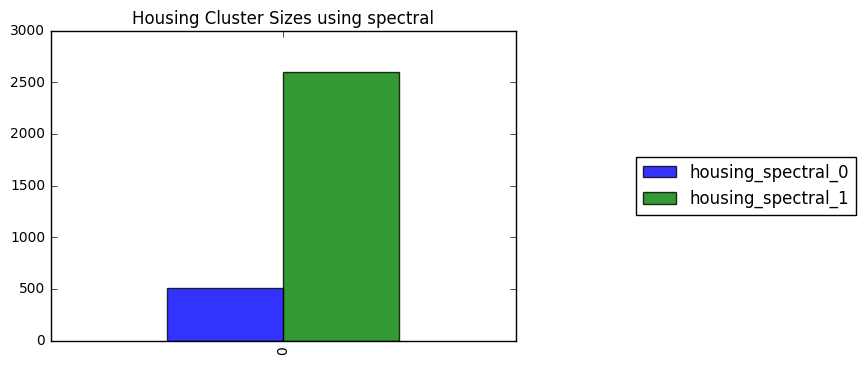

In [32]:
for i in range(3):
    plot_cluster("housing", suffixes[i], "Housing Cluster Sizes").show()

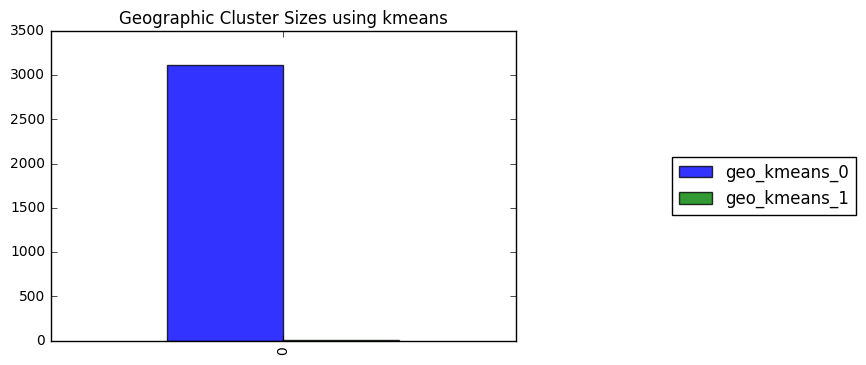

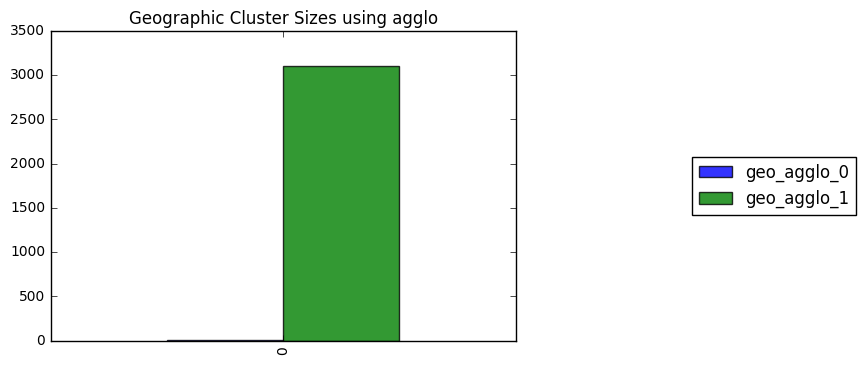

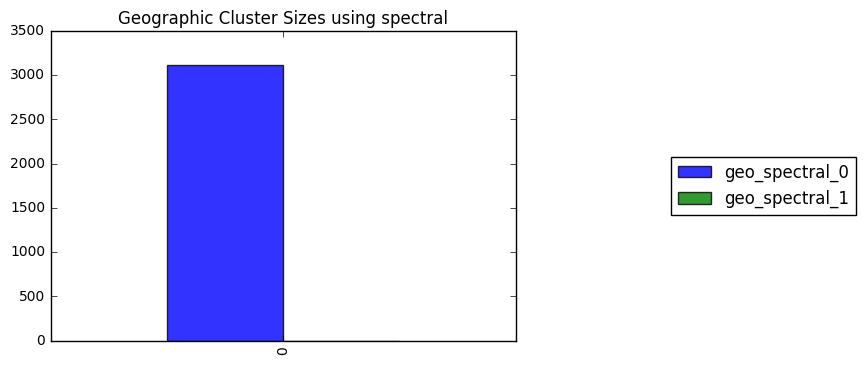

In [33]:
for i in range(3):
    plot_cluster("geo", suffixes[i], "Geographic Cluster Sizes").show()

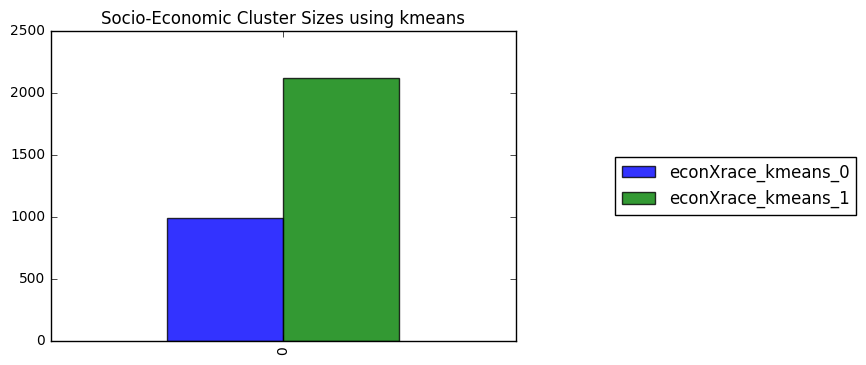

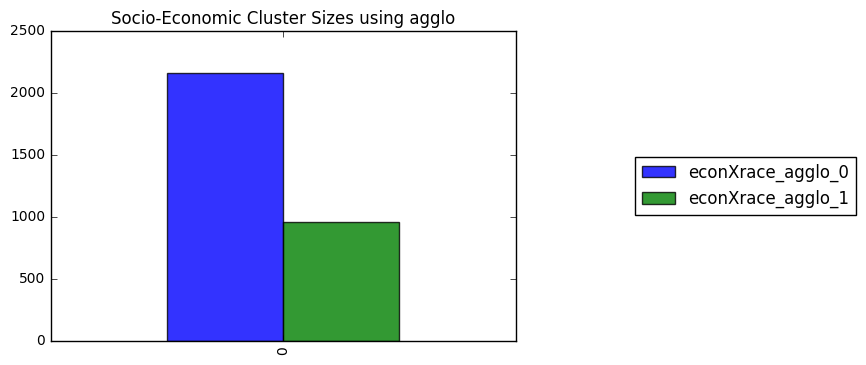

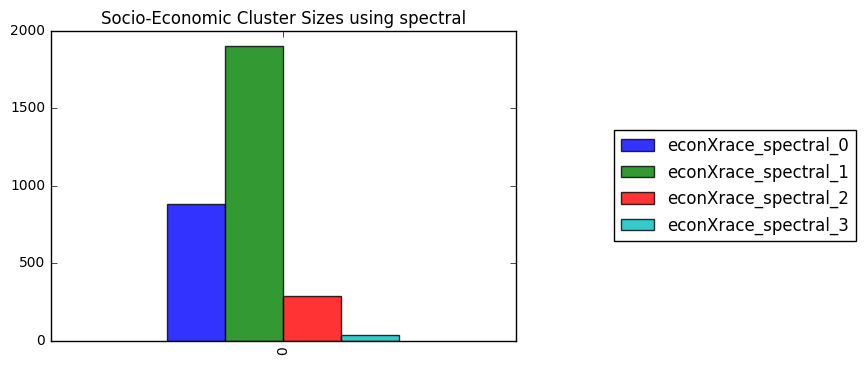

In [34]:
for i in range(3):
    plot_cluster("econXrace", suffixes[i], "Socio-Economic Cluster Sizes").show()

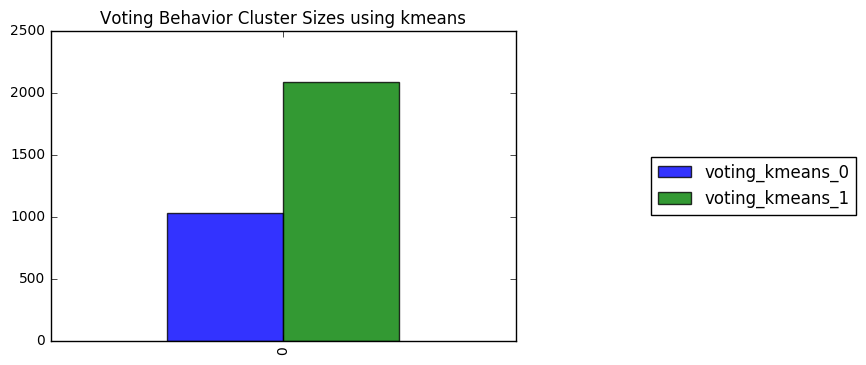

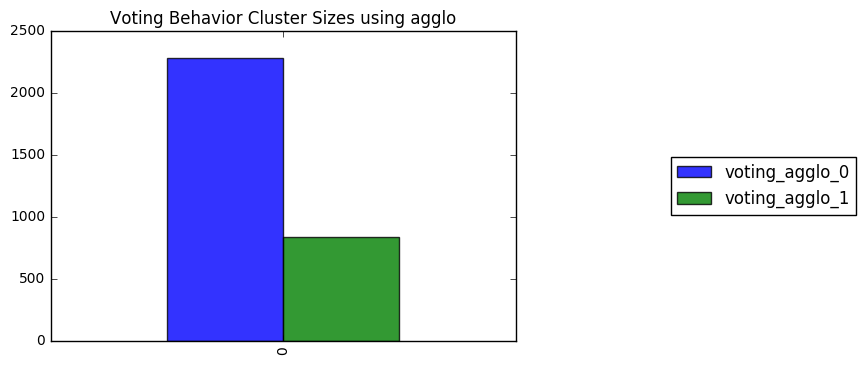

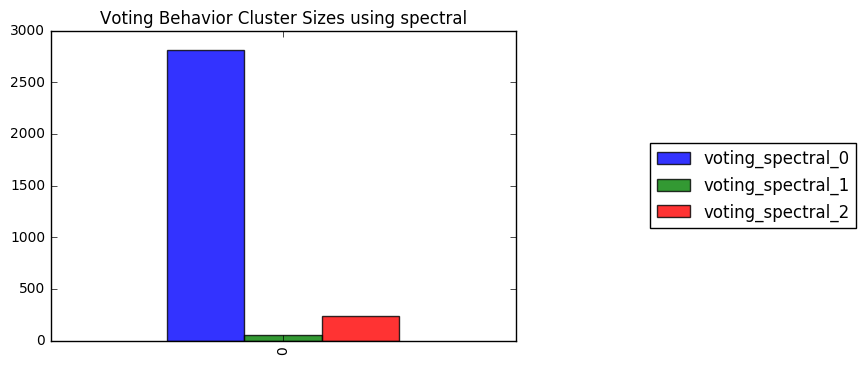

In [35]:
for i in range(3):
    plot_cluster("voting", suffixes[i], "Voting Behavior Cluster Sizes").show()